In [ ]:
import numpy  as np                       
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli
import time, sys  
%matplotlib inline 

In [ ]:
%%capture
!pip install ipython-autotime
%load_ext autotime

time: 472 µs


In [ ]:
save_plot = 0

time: 343 µs


In [ ]:
nx_up = 32
nx_lx = 128

samples = 100
s = np.random.uniform(1, 25, samples)
phi_up = np.zeros((nx_up, samples))
phi_lx = np.zeros((nx_lx, samples))

time: 685 µs


In [ ]:
for _ in range(len(s)):
    sharpen = s[_]

    u = 1.0         
    L = 2.0        
    T = 1.0        
    cfl = 0.1      
    periodic = 0    # periodicity on/off 

    # define initial condition   
    def ic(x, sharpen):
        xcenter = 0.5   # location of the gaussian center
        phi_ic = np.exp(-sharpen*(x - xcenter)**2) 
        return phi_ic

    x = np.linspace(0,L,100)
    phi = np.zeros(100)  
    for i in range(100):
        phi[i]=ic(x[i], sharpen)

    # set initial condition   
    def initialize(nno,x,phi):
        for i in range(nno):
            phi[i]=ic(x[i], sharpen)

    # compute errors
    def compute_exact(nno,time,x,phi_exact):
        time_shift = time
        if periodic and time*u > L:
            a = divmod(time,L/u)
            time_shift = a[1]
        for i in range(nno):
            phi_exact[i]=ic(x[i]-u*time_shift, sharpen)

    # plot the solution and compare to the exact one
    def plot_solution(nno,x,phi,phi_exact):
        pl.clf()
        pl.plot(x,phi, '-',label='Computational')
        pl.plot(x, phi_exact, 'bs', label='Analytical')
        pl.xlabel("x",fontsize=16)  
        pl.ylabel(r"$\phi $",fontsize=16)
        pl.legend()

    # First Order Upwind
    def update_upwind(nno,dx,dt,phi):
        phi_old = phi.copy() 
        for i in range(1, nno-1):
            im = i-1
            phi[i] = phi_old[i]-u*dt/dx*(phi_old[i] - phi_old[im])

    # Lax Wendroff
    def update_laxwendroff(nno,dx,dt,phi):
        phi_old = phi.copy() 
        for i in range(1, nno-1):
            im = i-1
            ip = i+1
            phi[i] = phi_old[i]-0.5*u*dt/dx*((phi_old[ip]-phi_old[im])
                      -u*dt/dx*(-2.*phi_old[i]+phi_old[im]+phi_old[ip]))

    # set boundary condition  
    def bc(nno,x,phi,time):
        if (periodic):
            phi[0]=phi[nno-2] #apply periodicity @ x=0
            phi[nno-1]=phi[1] #apply periodicity @ x=L
        else:
            phi[0]=ic(x[0]-u*time, sharpen) #ncross the right boundary
            #phi[nno-1]=phi[nno-2] #zero-gradient?
            phi[nno-1]=ic(x[nno-1]-u*time, sharpen) #cross the right boundary

    # solve the PDE
    def solve(nno,scheme="upwind",plot=0):  
        #by default use upwind and plot solution
        start = time.time() 
        dx = L / (nno-1)    # spacing of the nodes
        x = np.linspace(0,L,nno)  #grid generation!
        phi = np.zeros(nno)  
        phi_exact = np.zeros(nno)  
        initialize(nno,x,phi) #initialize
        mytime = 0
        nts = 0
        dt = cfl*dx/u
        while mytime < T:  #integrate up to time T
            bc(nno,x,phi,mytime)
            nts = nts + 1
            mytime = mytime + dt  
            # update the solution with a finite difference scheme (explicit)
            if scheme == "upwind": 
                update_upwind(nno,dx,dt,phi)
            elif scheme == "laxwendroff":
                update_laxwendroff(nno,dx,dt,phi)
        # compare the solution with the exact and compute the L2 norm
        compute_exact(nno,mytime,x,phi_exact)
        end = time.time()
        if plot:
            plot_solution(nno,x,phi,phi_exact)

        return phi 
    
    phi_up[:,_] = solve(nx_up,"upwind",0)
    phi_lx[:,_] = solve(nx_lx,"laxwendroff",0)

time: 12.1 s


In [ ]:
A = phi_up

eps = 0.001
k, idx, proj = sli.interp_decomp(A, eps)

print("rank = ",k)
print("idx = ",idx.shape)
print("proj = ",proj.shape)

rank =  5
idx =  (100,)
proj =  (5, 95)
time: 21.5 ms


In [ ]:
B = sli.reconstruct_skel_matrix(A, k, idx)
P = sli.reconstruct_interp_matrix(idx, proj)
C = sli.reconstruct_matrix_from_id(B, idx, proj) # C = P*B
print("B = ",B.shape)
print("P = ",P.shape)
print("C = ",C.shape)

B =  (32, 5)
P =  (5, 100)
C =  (32, 100)
time: 1.03 ms


In [ ]:
print("Frob Error = ",np.linalg.norm(A-C))
diff = sli.estimate_spectral_norm_diff(A, C)
print("Spectral Norm of Difference = ",diff)

Frob Error =  0.010670862653275208
Spectral Norm of Difference =  0.010625945483808456
time: 3.14 ms


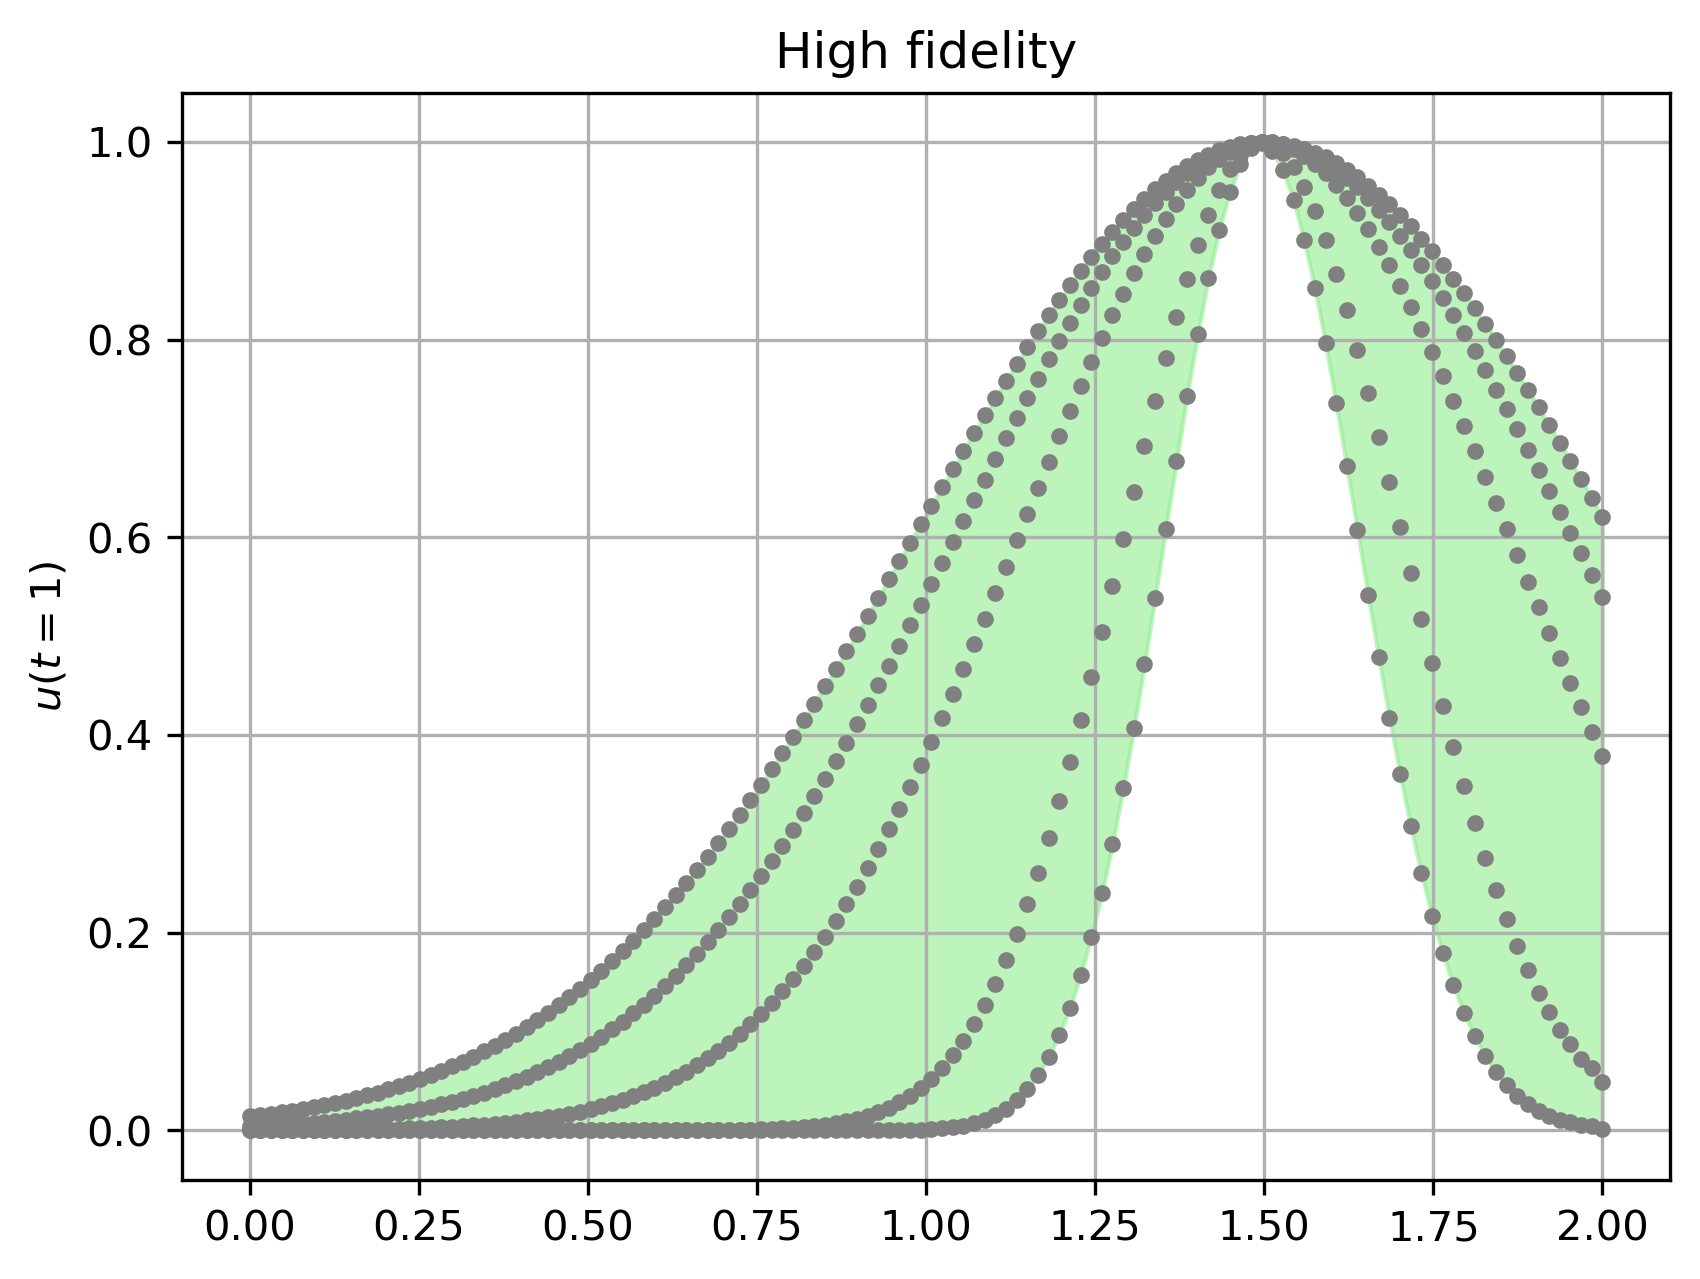

time: 459 ms


In [ ]:
# plot results
X = np.linspace(0,L,nx_lx)
# generate uncertainty envelope
low_bnd = np.zeros(nx_lx)
for _ in range(nx_lx):
    low_bnd[_] = min(phi_lx[_,:])
    
upp_bnd = np.zeros(nx_lx)
for _ in range(nx_lx):
    upp_bnd[_] = max(phi_lx[_,:])

fig1 = plt.figure(figsize=[6.4, 4.8],dpi=300)
ax = fig1.add_subplot(1,1,1)
ax.plot(X,phi_lx[:,idx[0:k]], '.', color='grey')
ax.set_ylabel('$u(t = 1)$')
ax.grid('on')
ax.set_title('High fidelity')
ax.fill_between(X,low_bnd,upp_bnd,color='lightgreen',alpha=0.6)      # uq bounds

if save_plot:
    plt.savefig("hf-red-2.png",bbox_inches='tight')

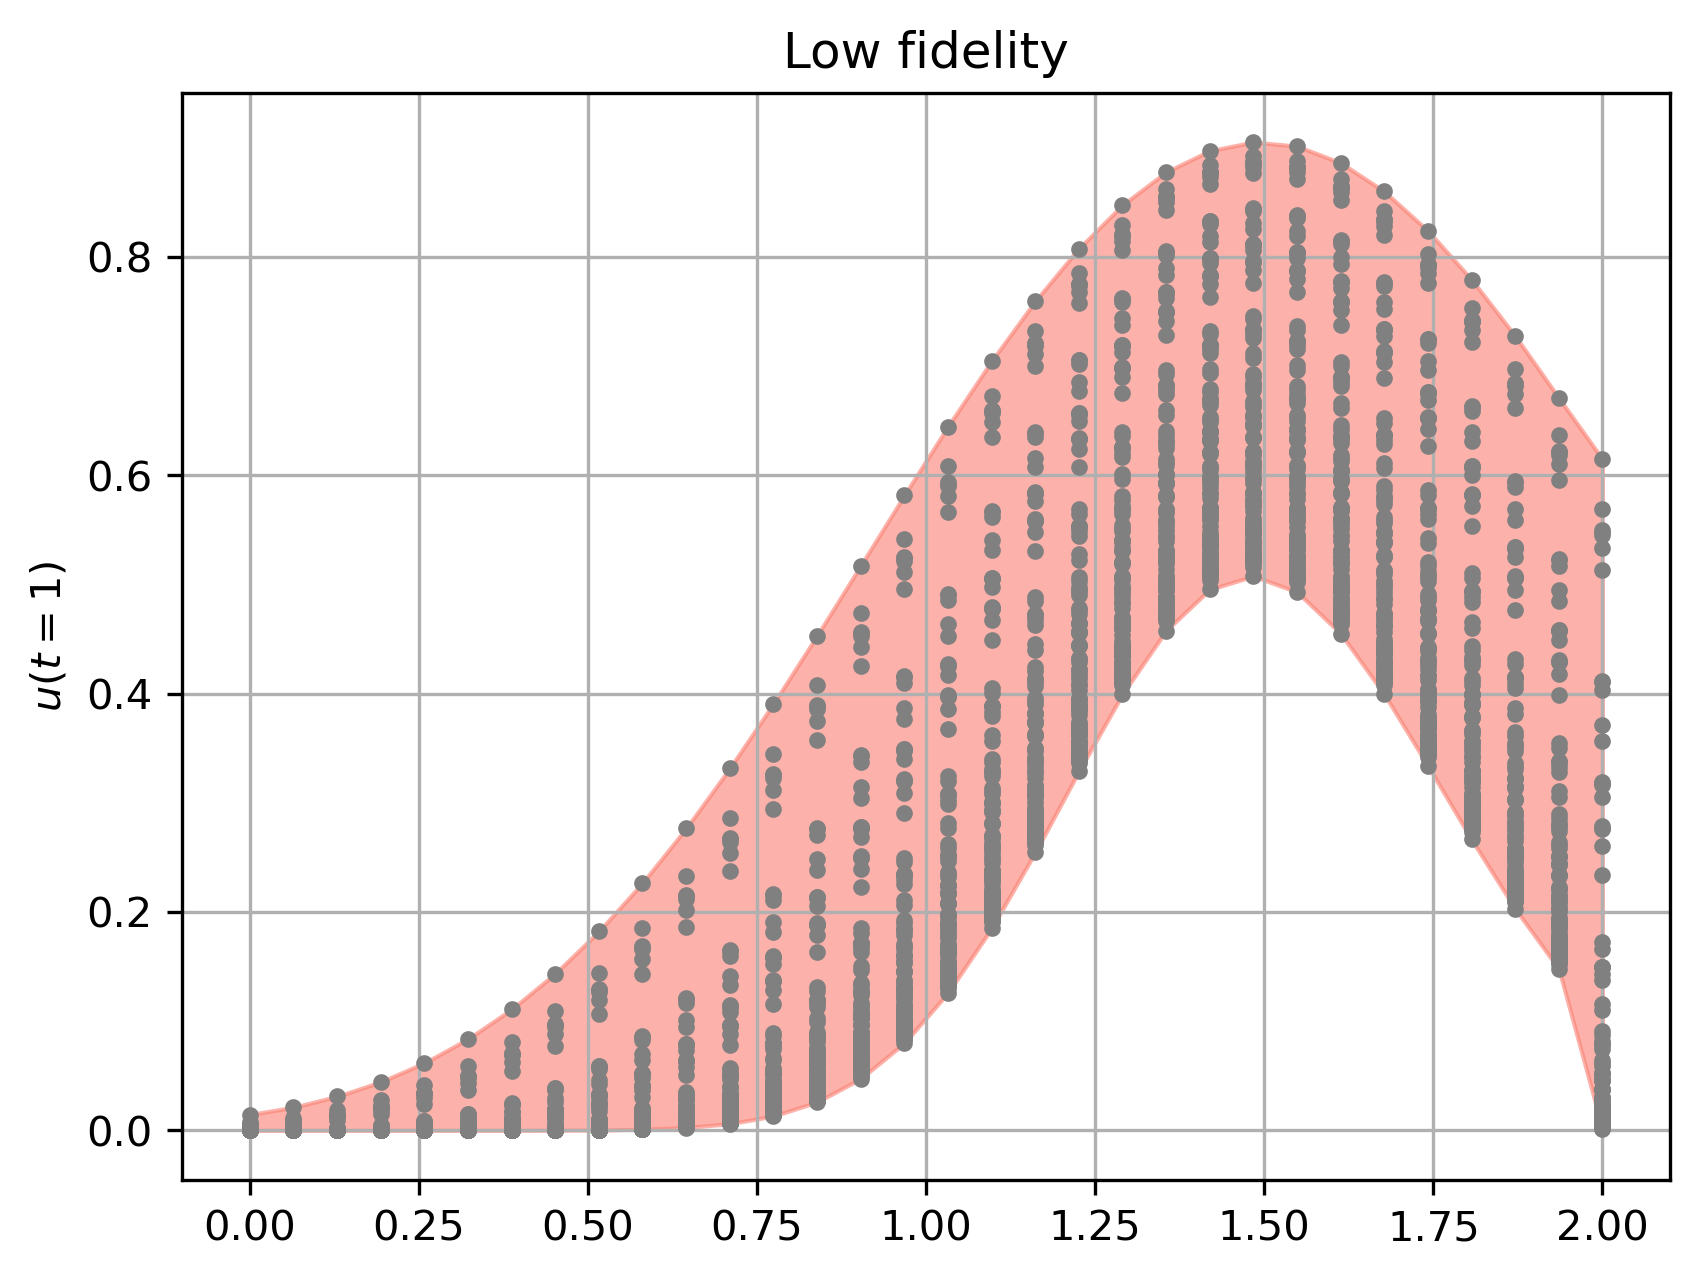

time: 361 ms


In [ ]:
# plot results
X = np.linspace(0,L,nx_up)
# generate uncertainty envelope
low_bnd = np.zeros(nx_up)
for _ in range(nx_up):
    low_bnd[_] = min(phi_up[_,:])
    
upp_bnd = np.zeros(nx_up)
for _ in range(nx_up):
    upp_bnd[_] = max(phi_up[_,:])

fig2 = plt.figure(figsize=[6.4, 4.8],dpi=300)
ax = fig2.add_subplot(1,1,1)
ax.plot(X,phi_up, '.', color='grey')
ax.set_ylabel('$u(t = 1)$')
ax.set_title('Low fidelity')
ax.grid('on')
ax.fill_between(X,low_bnd,upp_bnd,color='salmon',alpha=0.6) 

if save_plot:
    plt.savefig("lf.png",bbox_inches='tight')

In [ ]:
phi_rcn = np.dot(phi_lx[:,idx[0:k]],P) # reconstructed high-fidelity solution

time: 519 µs


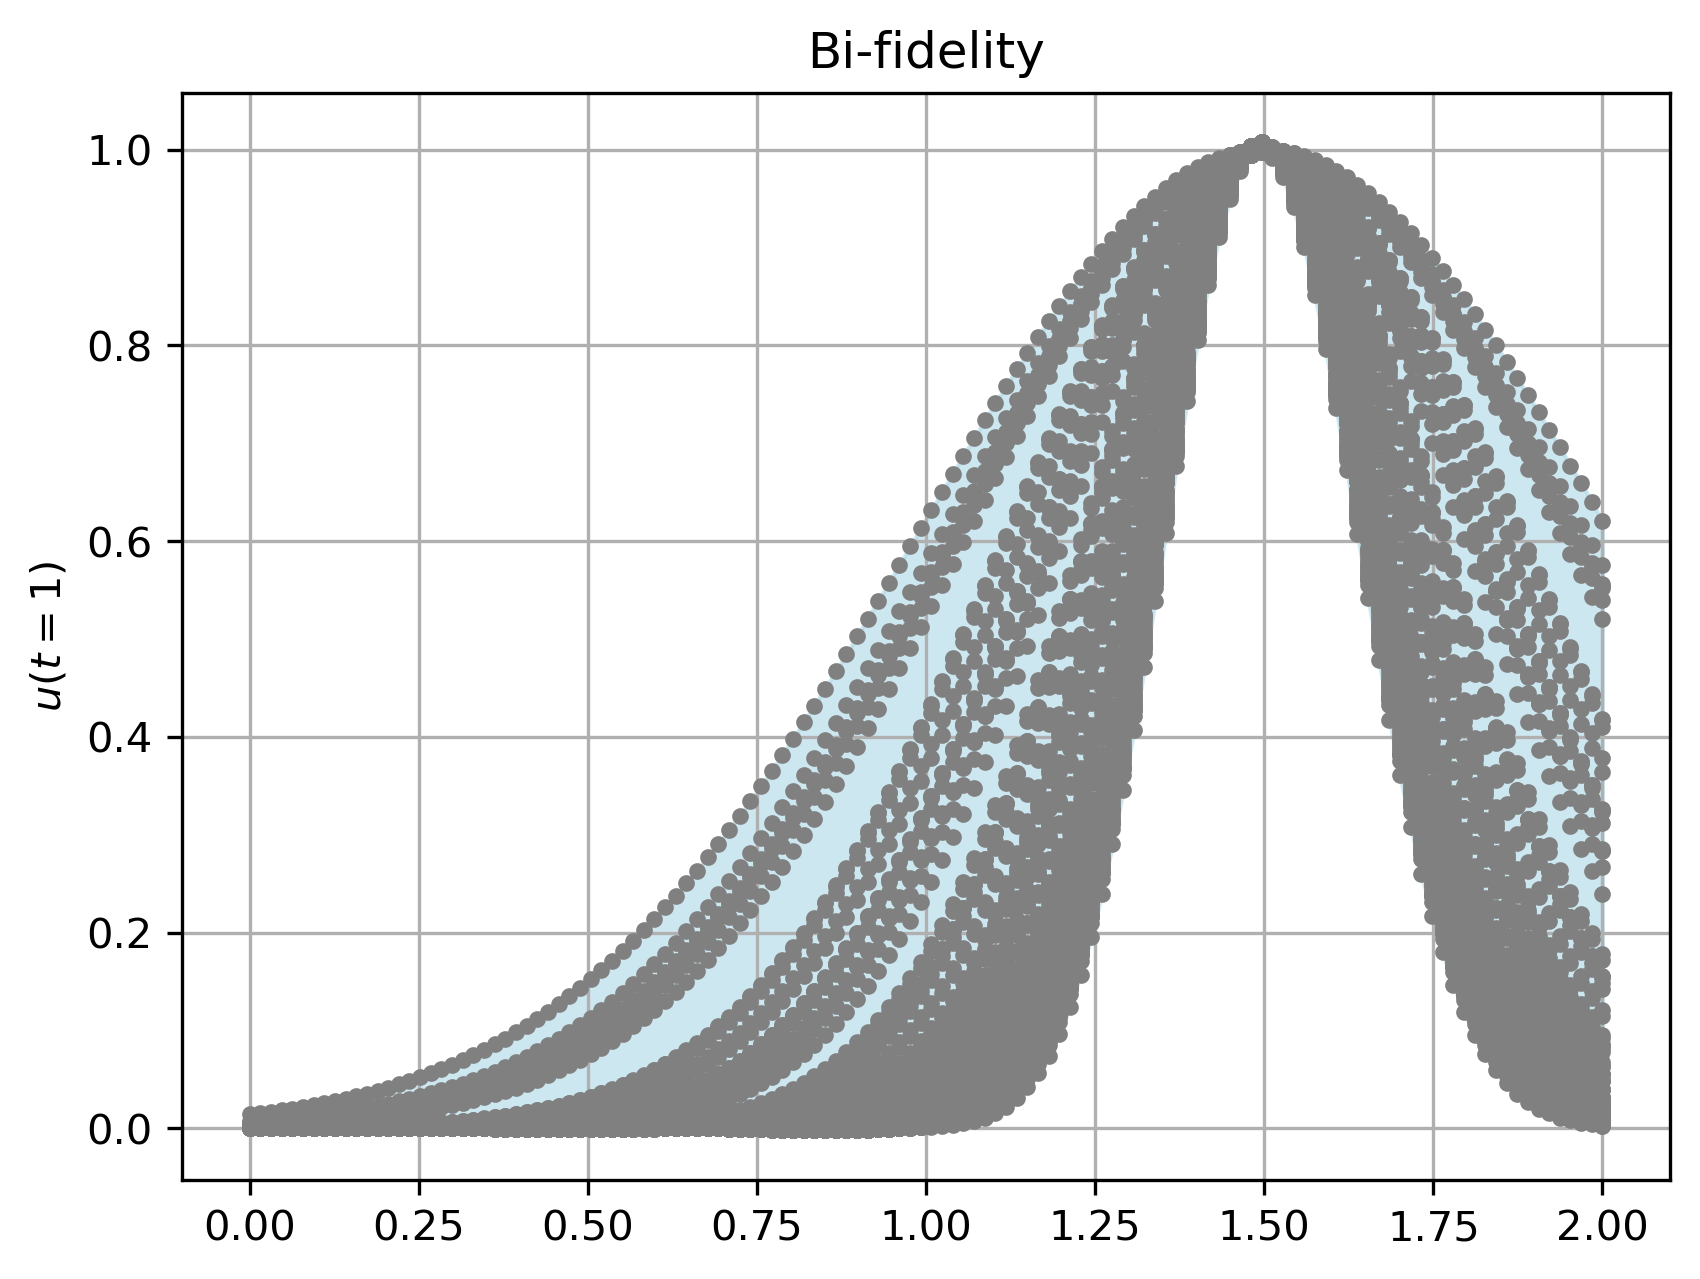

time: 388 ms


In [ ]:
# plot results
X = np.linspace(0,L,nx_lx)
# generate uncertainty envelope
low_bnd = np.zeros(nx_lx)
for _ in range(nx_lx):
    low_bnd[_] = min(phi_rcn[_,:])
    
upp_bnd = np.zeros(nx_lx)
for _ in range(nx_lx):
    upp_bnd[_] = max(phi_rcn[_,:])

fig1 = plt.figure(figsize=[6.4, 4.8],dpi=300)
ax = fig1.add_subplot(1,1,1)
ax.plot(X,phi_rcn, '.', color='grey')
ax.set_ylabel('$u(t = 1)$')
ax.set_title('Bi-fidelity')
ax.grid('on')
ax.fill_between(X,low_bnd,upp_bnd,color='lightblue',alpha=0.6)      # uq bounds

if save_plot:
    plt.savefig("bf-2.png",bbox_inches='tight')